# Masked Autoencoders Are Scalable Vision Learners

This notebook is a TF2 implementation of [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377) by He et. al.

# Imports & Setup

In [1]:
! pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.5 MB/s 


In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

# setting seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 512
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 100

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 10

# AUGMENTATION
IMAGE_SIZE = 72  # We'll resize input images to this size
PATCH_SIZE = 6  # Size of the patches to be extract from the input images
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# ENCODER and DECODER
PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 8
DEC_NUM_HEADS = 4
DEC_LAYERS = 8
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]  # Size of the transformer layers

# Dataset

Using CIFAR100 for our implementation.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

169017344/169001437 [==============================] - 3s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = (
    train_ds
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = (
    val_ds
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = (
    test_ds
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Data Augmentation

In [6]:
def get_augmentation_model():
    model = keras.Sequential([
        layers.Rescaling(1/255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        )],
        name="data_augmentation")
    return model

def get_test_augmentation_model():
    model = keras.Sequential([
        layers.Rescaling(1/255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="test_data_augmentation")
    return model

# Create Patches

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        # assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3)
        self.resize = layers.Reshape((-1, patch_size*patch_size*3))

    def call(self, images, show_patch=False):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)

        # If the user wants to view an image and its corresponding
        # patches.
        if show_patch:
            self.show_patched_image(images, patches)
        
        return patches
    
    def show_patched_image(self, images, patches):
        # Here we will accept batches patches but only show
        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[0]))
        plt.axis("off")
        plt.show()
        
        n = int(np.sqrt(NUM_PATCHES))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[0]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()
    
    # Useful for the training monitor
    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patches):
        # this reconstructs one image at a time
        # does not work with batched images
        patches_tmp = tf.reshape(patches, (NUM_PATCHES, PATCH_SIZE, PATCH_SIZE ,3))
        rows = tf.split(patches_tmp, IMAGE_SIZE//PATCH_SIZE, axis=0)
        rows = [tf.concat(tf.unstack(x),axis=1) for x in rows]
        reconstructed = tf.concat(rows,axis=0)
        return reconstructed

In [8]:
images = tf.constant(x_train[0:1])
augmentation_model = get_augmentation_model()
augmeneted_images = augmentation_model(images)
patch_layer = Patches(patch_size=PATCH_SIZE)

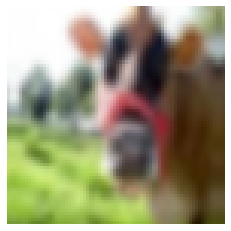

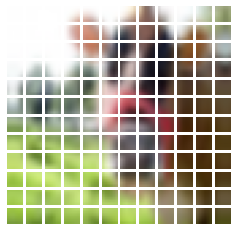

In [9]:
patches = patch_layer(
    images=augmeneted_images,
    show_patch=True)

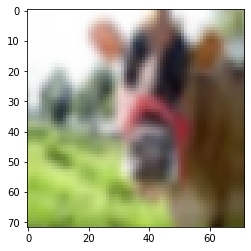

In [10]:
image = patch_layer.reconstruct_from_patch(patches[0])
plt.imshow(image)
plt.show()

# Patch Encoder

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size, projection_dim, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.batch_size = batch_size

        # this is a trainable mask token as suggested in the paper.
        self.mask_token = tf.Variable(
            tf.random.normal(
                [1, patch_size*patch_size*3]
            ))

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # create the projection layer
        self.projection = layers.Dense(units=self.projection_dim)
        
        # create the positional embedding layer
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim)
        
        # 75% of number of patches should be masked
        self.num_mask = int(0.75 * self.num_patches)

        # create random indices from a uniform distribution and then split
        # it into mask and unmask indices
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(self.batch_size, self.num_patches)),
            axis=-1)
        self.mask_indices = rand_indices[:, :self.num_mask]
        self.unmask_indices = rand_indices[:, self.num_mask:]

    def call(self, patch, show_mask_img=False):
        # patch shape = (B, num_patches, p*p*3)
        # get the positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(pos_embeddings, [self.batch_size, 1, 1]) # (B, num_patches, projection_dim)

        # embedd the patches
        patch_embeddings = self.projection(patch) + pos_embeddings # (B, num_patches, projection_dim)

        # the encoder input is the unmasked patch embeddings
        unmasked_embeddings = tf.gather(
            patch_embeddings,
            self.unmask_indices,
            axis=1,
            batch_dims=1) # (B, unmask_numbers, projection_dim)

        # get the unmasked and masked positions
        unmasked_positions = tf.gather(
            pos_embeddings,
            self.unmask_indices,
            axis=1,
            batch_dims=1) # (B, unmask_numbers, projection_dim)
        masked_positions = tf.gather(
            pos_embeddings,
            self.mask_indices,
            axis=1,
            batch_dims=1) # (B, mask_numbers, projection_dim)

        # repeat the mask token number of mask times
        # mask tokens replace the masks of the image
        mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
        mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...],
                repeats=self.batch_size,
                axis=0)

        # get the masked embeddings
        masked_embeddings = self.projection(mask_tokens) + masked_positions

        if show_mask_img:
            self.show_masked_image(patch)

        return unmasked_embeddings, masked_embeddings, unmasked_positions

    def show_masked_image(self, patches):
        unmasked_patches = tf.gather(
            patches,
            self.unmask_indices,
            axis=1,
            batch_dims=1)

        # necessary for plotting
        ids = tf.argsort(self.unmask_indices)
        sorted_unmask_indices = tf.sort(self.unmask_indices)
        unmasked_patches = tf.gather(
            unmasked_patches,
            ids,
            batch_dims=1)
        
        n = int(np.sqrt(NUM_PATCHES))
        unmask_index = sorted_unmask_indices[0]
        unmasked_patch = unmasked_patches[0]

        plt.figure(figsize=(4, 4))

        count = 0
        for i in range(144):
            ax = plt.subplot(n, n, i + 1)

            if count<PATCH_SIZE*PATCH_SIZE and unmask_index[count].numpy() == i:
                patch = unmasked_patch[count]
                patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
                plt.imshow(keras.utils.img_to_array(patch_img))
                plt.axis("off")
                count = count+1
            else:
                patch_img = tf.zeros((PATCH_SIZE, PATCH_SIZE, 3))
                plt.imshow(keras.utils.img_to_array(patch_img))
                plt.axis("off")
        plt.show()

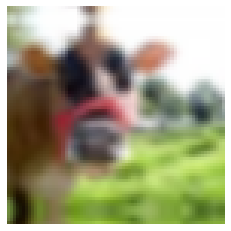

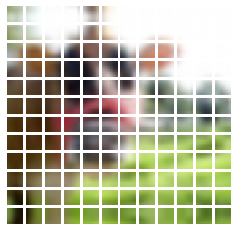

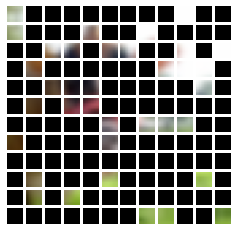

In [12]:
images = tf.constant(x_train[0:1])
augmentation_model = get_augmentation_model()
augmeneted_images = augmentation_model(images)
patch_layer = Patches(patch_size=PATCH_SIZE)
patches = patch_layer(augmeneted_images, True)

patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=1)
unmasked_embeddings, masked_embeddings, unmasked_positions = patch_encoder(
    patch=patches,
    show_mask_img=True)

# Multi-Layer Perceptron

In [13]:
def get_mlp(hidden_units, dropout_rate):
    layers_list = []
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=tf.nn.gelu))
        layers_list.append(layers.Dropout(dropout_rate))
    
    model = keras.Sequential(layers_list)
    return model

# Encoder

In [14]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        
    def build(self, input_shape):
        (_, self.num_unmask, self.projection_dim) = input_shape
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.add1 = layers.Add()
        self.add2 = layers.Add()

        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim//self.num_heads,
            dropout=0.1
        )
    
    def call(self, inputs):
        for _ in range(self.num_layers):
            # Layer normalization 1.
            x1 = self.layer_norm1(inputs)
            # Create a multi-head attention layer.
            attention_output = self.mha1(query=x1, value=x1)
            # Skip connection 1.
            x2 = self.add1([attention_output, inputs])
            # Layer normalization 2.
            x3 = self.layer_norm2(x2)
            # MLP.
            x3 = self.mlp(x3)
            # Skip connection 2.
            inputs = self.add2([x3, x2])

        # Create the encoder ouputs
        encoder_outputs = self.layer_norm3(inputs)
        
        return encoder_outputs

# Decoder

In [15]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, num_heads, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.patch_size = patch_size

    def build(self, input_shape):
        (_, self.num_patches, self.projection_dim) = input_shape
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)

        self.add1 = layers.Add()
        self.add2 = layers.Add()
        
        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim//self.num_heads,
            dropout=0.1)
        
        self.dense = layers.Dense(
            units=self.patch_size*self.patch_size*3,
            activation="sigmoid")
    
    def call(self, inputs):
        for _ in range(self.num_layers):
            # Layer normalization 1.
            x1 = self.layer_norm1(inputs)
            # Create a multi-head attention layer.
            attention_output = self.mha1(query=x1, value=x1)
            # Skip connection 1.
            x2 = self.add1([attention_output, inputs])
            # Layer normalization 2.
            x3 = self.layer_norm2(x2)
            # MLP.
            x3 = self.mlp(x3)
            # Skip connection 2.
            inputs = self.add1([x3, x2])

        # Create the encoder ouputs
        decoder_outputs = self.layer_norm3(inputs)
        decoder_outputs = self.dense(decoder_outputs)
        return decoder_outputs

# MaskedAutoEncoder Model
This is the trianer model. We implement this to train the encoder and the decoder with the `model.fit` API

In [16]:
class MaskedAutoencoder(keras.Model):
    def __init__(self, augmentation_model, patch_layer, patch_encoder, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.augmentation_model = augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
    
    def compile(self, optimizer, loss):
        super().compile()
        self.optimizer = optimizer
        self.loss = loss
        self.loss_tracker = keras.metrics.Mean(name="loss")
    
    def calculate_loss(self, images):
        # Augment the input images
        augmeneted_images = self.augmentation_model(images)

        # Patch the augmented images
        patches = self.patch_layer(augmeneted_images)

        # Encode the patches
        (unmasked_embeddings, masked_embeddings, unmasked_positions) = self.patch_encoder(patches)
        encoder_outputs = self.encoder(unmasked_embeddings)
        
        # Create the decoder inputs
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        
        # Decode the inputs
        decoder_outputs = self.decoder(decoder_inputs)

        loss_patch = tf.gather(
            patches,
            self.patch_encoder.mask_indices,
            axis=1,
            batch_dims=1)
        loss_output = tf.gather(
            decoder_outputs,
            self.patch_encoder.mask_indices,
            axis=1,
            batch_dims=1)             

        # Compute the total loss
        total_loss = self.loss(loss_patch, loss_output)

        return total_loss

    
    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss = self.calculate_loss(images)
        
        # Apply gradients
        train_vars = [
            self.augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g,v))
        self.optimizer.apply_gradients(tv_list)

        # Update the trackers.
        self.loss_tracker.update_state(total_loss)

        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, images):
        total_loss = self.calculate_loss(images)
        
        # Update the trackers.
        self.loss_tracker.update_state(total_loss)

        return {"loss": self.loss_tracker.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker]

In [17]:
keras.backend.clear_session()

augmentation_model = get_augmentation_model()
patch_layer = Patches(patch_size=PATCH_SIZE)
patch_encoder = PatchEncoder(
    patch_size=PATCH_SIZE,
    projection_dim=PROJECTION_DIM,
    batch_size=BATCH_SIZE)
encoder = Encoder(
    num_layers=ENC_LAYERS,
    num_heads=ENC_NUM_HEADS)
decoder = Decoder(
    num_layers=DEC_LAYERS,
    num_heads=DEC_NUM_HEADS,
    patch_size=PATCH_SIZE)

mae = MaskedAutoencoder(
    augmentation_model=augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder)

optimizer = tfa.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

mae.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
)

In [18]:
test_images = next(iter(test_ds))
aug_model = get_test_augmentation_model()

class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_augmeneted_images = aug_model(test_images)
        test_patches = self.model.patch_layer(test_augmeneted_images)
        (test_unmasked_embeddings, test_masked_embeddings, test_unmasked_positions) = self.model.patch_encoder(test_patches)
        test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
        test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
        test_decoder_inputs = tf.concat([test_encoder_outputs, test_masked_embeddings], axis=1)
        test_decoder_outputs = self.model.decoder(test_decoder_inputs)

        # Plot the images
        original = self.model.patch_layer.reconstruct_from_patch(test_patches[0])
        reconstructed = self.model.patch_layer.reconstruct_from_patch(test_decoder_outputs[0])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        ax[0].imshow(tf.keras.preprocessing.image.array_to_img(original))
        ax[0].set_title(f"Original: {epoch:03d}")

        ax[1].imshow(tf.keras.preprocessing.image.array_to_img(reconstructed))
        ax[1].set_title(f"Resonstructed: {epoch:03d}")
        
        plt.show()
        plt.close()

In [19]:
train_callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    TrainMonitor()
]

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.0769

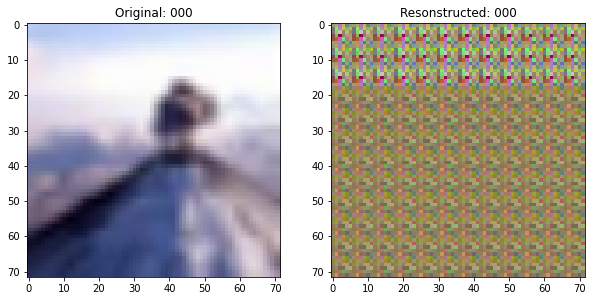

15/15 [==============================] - 21s 559ms/step - loss: 0.0769 - val_loss: 0.0692 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.0671

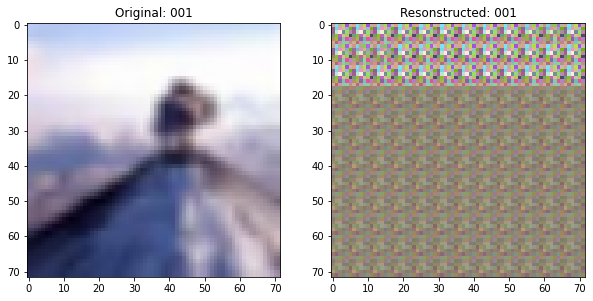

15/15 [==============================] - 6s 406ms/step - loss: 0.0671 - val_loss: 0.0659 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 0.0589

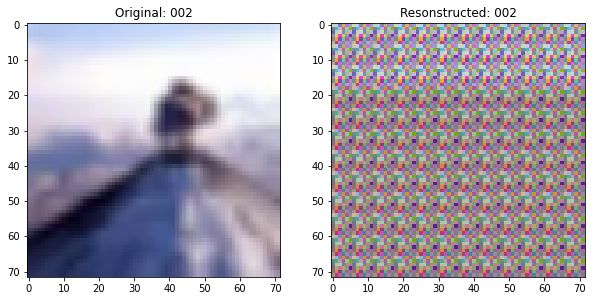

15/15 [==============================] - 6s 406ms/step - loss: 0.0589 - val_loss: 0.0531 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.0492

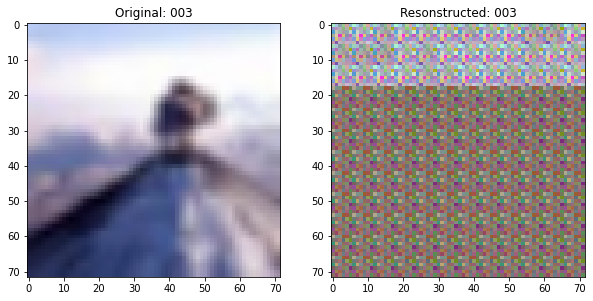

15/15 [==============================] - 6s 407ms/step - loss: 0.0492 - val_loss: 0.0467 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - ETA: 0s - loss: 0.0453

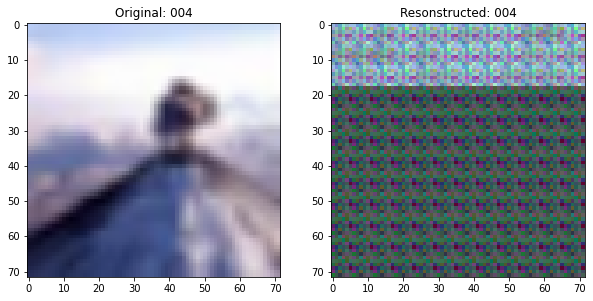

15/15 [==============================] - 6s 406ms/step - loss: 0.0453 - val_loss: 0.0452 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - ETA: 0s - loss: 0.0439

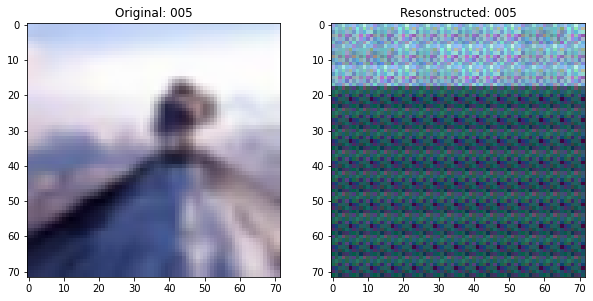

15/15 [==============================] - 6s 406ms/step - loss: 0.0439 - val_loss: 0.0434 - lr: 0.0010
Epoch 7/10
15/15 [==============================] - ETA: 0s - loss: 0.0430

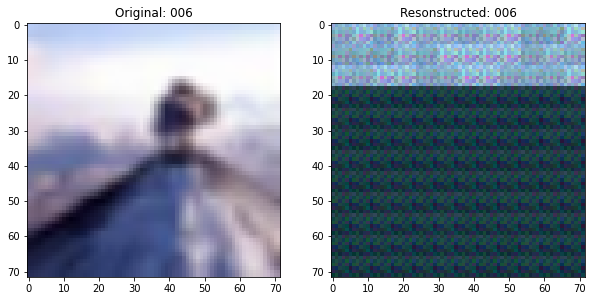

15/15 [==============================] - 6s 406ms/step - loss: 0.0430 - val_loss: 0.0430 - lr: 0.0010
Epoch 8/10
15/15 [==============================] - ETA: 0s - loss: 0.0421

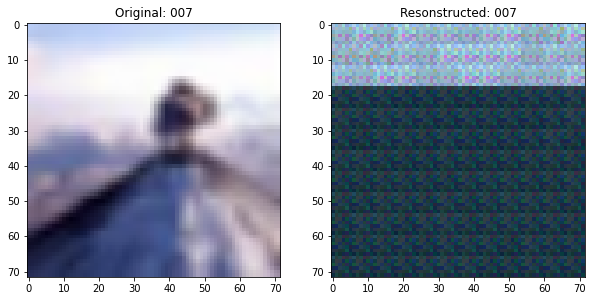

15/15 [==============================] - 6s 406ms/step - loss: 0.0421 - val_loss: 0.0417 - lr: 0.0010
Epoch 9/10
15/15 [==============================] - ETA: 0s - loss: 0.0413

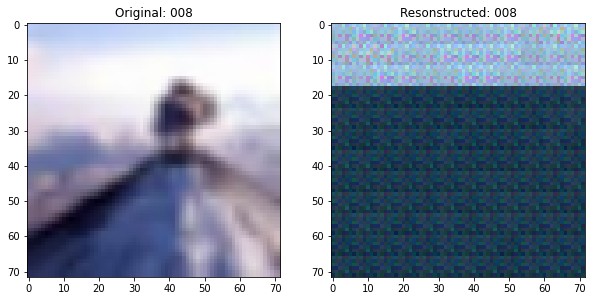

15/15 [==============================] - 6s 421ms/step - loss: 0.0413 - val_loss: 0.0414 - lr: 0.0010
Epoch 10/10
15/15 [==============================] - ETA: 0s - loss: 0.0419

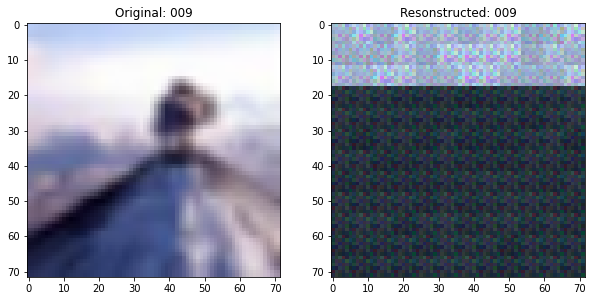

15/15 [==============================] - 6s 406ms/step - loss: 0.0419 - val_loss: 0.0422 - lr: 0.0010


In [20]:
history = mae.fit(
    train_ds,
    steps_per_epoch=15,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=5,
    callbacks=train_callbacks)

In [21]:
loss = mae.evaluate(test_ds, steps=5)
print(f"Loss: {loss:.2f}")

5/5 [==============================] - 1s 121ms/step - loss: 0.0418
Loss: 0.04
